## Installation

In [1]:

!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=2aa0f05392c467ebaa989906b93772d3ff32837694113e9468ebc0ad0c6403ac
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer


from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover


from pyspark.sql.functions import regexp_replace
import re
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from pyspark.sql import functions as F

from pyspark.sql.functions import explode, col,split

from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Reading CSV and merging

In [3]:
spark = SparkSession.builder \
    .appName("Read CSV into DataFrame") \
    .getOrCreate()


In [4]:
df1 = spark.read.csv("/content/2022_4.csv", header=True, inferSchema=True)
# df2=spark.read.csv("/content/2022_5.csv", header=True, inferSchema=True)
# df3 = spark.read.csv("/content/2022_6.csv", header=True, inferSchema=True)
# df4=spark.read.csv("/content/2022_7.csv", header=True, inferSchema=True)
# df5 = spark.read.csv("/content/2022_8.csv", header=True, inferSchema=True)
# df6=spark.read.csv("/content/2022_9.csv", header=True, inferSchema=True)
# df7 = spark.read.csv("/content/2022_10.csv", header=True, inferSchema=True)
# df8=spark.read.csv("/content/2022_11.csv", header=True, inferSchema=True)
# df9 = spark.read.csv("/content/2022_12.csv", header=True, inferSchema=True)
# df10=spark.read.csv("/content/2022_13.csv", header=True, inferSchema=True)
# df11 = spark.read.csv("/content/2022_14.csv", header=True, inferSchema=True)
df1.show()

+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+
|        created_date|           tweet_id|           author_id|                text|          is_retweet|          retweet_id|   retweet_author_id|  dateid|
+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+
| 2022-01-22 00:00:00|1484677190230945801|        2815008193.0|RT @melenchon_202...|                NULL|                NULL|                NULL|    NULL|
|    #ConseilConsti…"|               True|1.484572290851422...|1.324766177919381...|            20220122|                NULL|                NULL|    NULL|
| 2022-01-22 00:00:01|1484677191715672069|1.184512866885558...|"""Only an except...|"" @lieven_anatol...|                NULL|                NULL|    NULL|
|https://t.co/k2U9...|              False|                

In [6]:
# #merging
# merged_df1 = df1
# merged_df2=merged_df1.union(df2)
# merged_df3=merged_df2.union(df3)
# merged_df4=merged_df3.union(df4)
# merged_df5=merged_df4.union(df5)
# merged_df6=merged_df5.union(df6)
# merged_df7=merged_df6.union(df7)
# merged_df8=merged_df7.union(df8)
# merged_df9=merged_df8.union(df9)
# merged_df10=merged_df9.union(df10)
# merged_df=merged_df10.union(df11)

# merged_df.count()

# #merged_df=df1
merged_df=df1
merged_df=merged_df.limit(10000)
merged_df.show()
merged_df.count()


+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+
|        created_date|           tweet_id|           author_id|                text|          is_retweet|          retweet_id|   retweet_author_id|  dateid|
+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+
| 2022-01-22 00:00:00|1484677190230945801|        2815008193.0|RT @melenchon_202...|                NULL|                NULL|                NULL|    NULL|
|    #ConseilConsti…"|               True|1.484572290851422...|1.324766177919381...|            20220122|                NULL|                NULL|    NULL|
| 2022-01-22 00:00:01|1484677191715672069|1.184512866885558...|"""Only an except...|"" @lieven_anatol...|                NULL|                NULL|    NULL|
|https://t.co/k2U9...|              False|                

10000

## Pre-Processing

In [7]:
#----------Pre-processing Starts here-----------

#merged_df = merged_df.withColumnRenamed("Tweet", "text")

# Select the specific column
selected_df = merged_df.select('text','retweet_id','is_retweet','retweet_author_id')
selected_df = selected_df.dropna(how='any')
# Drop duplicate rows based on the specific column
filtered_df = selected_df.dropDuplicates()

# Drop rows with null values in the specific column
#filtered_df = nodublicates.dropna(how='any')


# Remove mentions
mention_pattern = r'@\w+'

removed_mentions_df = filtered_df.withColumn('text', regexp_replace('text', mention_pattern, ''))
#removed_mentions_df.show()

# Remove URLs
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

removed_urls_df = removed_mentions_df.withColumn('text', regexp_replace('text', url_pattern, ''))
#removed_urls_df.show()

# Remove special characters
special_char_pattern = r'[^a-zA-Z0-9\s]'

removed_special_chars_df = selected_df.withColumn('text', regexp_replace('text', special_char_pattern, ''))
#removed_special_chars_df.show()

filtered1_df = removed_special_chars_df.na.drop(subset=['text'])
#filtered1_df.show()


# Remove emojis

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               u"\U0001F780-\U0001F7FF"
                               u"\U0001F800-\U0001F8FF"
                               u"\U0001F900-\U0001F9FF"
                               u"\U0001FA00-\U0001FA6F"
                               u"\U00002702-\U000027B0"
                               u"\ufe0f"
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emojis_udf = F.udf(remove_emojis, StringType())
cleaned_data = filtered1_df.withColumn("text", remove_emojis_udf("text"))
cleaned_data.show()
cleaned_data.count()

+--------------------+--------------------+----------+--------------------+
|                text|          retweet_id|is_retweet|   retweet_author_id|
+--------------------+--------------------+----------+--------------------+
|RT louannedlh il ...|1.484613467491479...|      True|        2191604457.0|
|RT FranckMonasse ...|1.484510655310876...|      True|1.223264769941147...|
|RT Gartondeau Vou...|1.484573055473102...|      True|8.130675321732506...|
|RT louannedlh il ...|1.484613467491479...|      True|        2191604457.0|
|RT louannedlh il ...|1.484613467491479...|      True|        2191604457.0|
|RT FrediBern Phil...|1.483106407423647...|      True|1.323369805227974...|
|RT GeWoessner Upd...|1.484629320115097...|      True|         122253091.0|
|RT louannedlh il ...|1.484613467491479...|      True|        2191604457.0|
|RT louannedlh il ...|1.484613467491479...|      True|        2191604457.0|
|RT escmk Salut Vi...|1.484651078801145...|      True|1.144574167481757...|
|RT ZemmourE

3903

In [14]:
# Initialize the Tokenizer
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
tokenized_data = tokenizer.transform(cleaned_data)

tokenized_data.select("text","tokens").show(truncate=False)
tokenized_data

+-------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                 |tokens                                                                                                                                                        |
+-------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|RT louannedlh il a pris des photos de filles voiles  la fac et les a mis sur twitter pr dire NON  ce genre daccout

DataFrame[text: string, retweet_id: string, is_retweet: string, retweet_author_id: string, tokens: array<string>]

In [11]:
# Initialize the StopWordsRemover
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=["rt", "pr", "des", "de", "et", "sur", "le", "les", "la", "que", "you", "a", "and", "his", "for", "from", "it", "in", "with", "an", "on", "are", "as", "at", "be", "by", "com", "if", "into", "like", "than", "this", "but", "his", "her", "she", "or", "if", "was", "were", "be", "have", "has", "had", "having", "will", "would", "can", "can't", "could", "shall", "should", "ought", "i", "i'd", "i'll", "i'm", "i've", "is", "it's", "you're", "you've", "yours", "he's", "she's", "there's", "where's", "it's", "that's", "when's", "how's", "why's", "all", "any", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "other", "so", "than", "too", "very", "can", "will", "just"])
filtered_data = remover.transform(tokenized_data)

filtered_data.select("filtered_tokens").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_tokens                                                                                                                                   |
+--------------------------------------------------------------------------------------------------------------------------------------------------+
|[louannedlh, il, pris, photos, filles, voiles, , fac, mis, twitter, dire, non, , ce, genre, daccoutrement, mais, il]                              |
|[franckmonasse, fabien, roussel, invit, france24, rfi, httpstcosv7c8ffovk, via, youtube]                                                          |
|[gartondeau, vous, vous, rendez, compte, si, mlenchon, ne, subissait, pas, cette, haine, constante, hystrique, toutes, part, fi, ce, ser]         |
|[louannedlh, il, pris, photos, filles, voiles, , fac, mis, twitter, dire, non, , ce, genre, daccoutrement

## Model training and sentimental analysis

In [15]:
def setup_nltk():
    nltk.download('vader_lexicon', quiet=True)



setup_nltk()

def nltk_sentiment(text):
    if text:
      sia = SentimentIntensityAnalyzer()
      sentiment_score = sia.polarity_scores(text)['compound']
      if sentiment_score>0:
        return "Positive"
      elif sentiment_score<0:
        return "Negative"
      else:
        return "Neutral"


# Register the UDF
sentiment_udf = udf(nltk_sentiment, StringType())
result_df = filtered_data.withColumn("result", sentiment_udf(col("text")))
result_df.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------+
|                text|          retweet_id|is_retweet|   retweet_author_id|              tokens|     filtered_tokens|  result|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------+
|RT louannedlh il ...|1.484613467491479...|      True|        2191604457.0|[rt, louannedlh, ...|[louannedlh, il, ...|Negative|
|RT FranckMonasse ...|1.484510655310876...|      True|1.223264769941147...|[rt, franckmonass...|[franckmonasse, f...| Neutral|
|RT Gartondeau Vou...|1.484573055473102...|      True|8.130675321732506...|[rt, gartondeau, ...|[gartondeau, vous...| Neutral|
|RT louannedlh il ...|1.484613467491479...|      True|        2191604457.0|[rt, louannedlh, ...|[louannedlh, il, ...|Negative|
|RT louannedlh il ...|1.484613467491479...|      True|        2191604457.0|[rt, louannedlh, ...|[louannedlh, il

In [39]:
# Replace the string values with numerical values
result_df = result_df.withColumn(
    "result_numeric",
    F.when(F.col("result") == "Positive", 1)
    .when(F.col("result") == "Negative", 2)
    .when(F.col("result") == "Neutral", 0)
    .otherwise(None)
)
result_df.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------+--------------+
|                text|          retweet_id|is_retweet|   retweet_author_id|              tokens|     filtered_tokens|  result|result_numeric|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------+--------------+
|RT louannedlh il ...|1.484613467491479...|      True|        2191604457.0|[rt, louannedlh, ...|[louannedlh, il, ...|Negative|             2|
|RT FranckMonasse ...|1.484510655310876...|      True|1.223264769941147...|[rt, franckmonass...|[franckmonasse, f...| Neutral|             0|
|RT Gartondeau Vou...|1.484573055473102...|      True|8.130675321732506...|[rt, gartondeau, ...|[gartondeau, vous...| Neutral|             0|
|RT louannedlh il ...|1.484613467491479...|      True|        2191604457.0|[rt, louannedlh, ...|[louannedlh, il, ...|Negative|             2|
|RT lo

In [40]:
# Encode sentiment labels
label_indexer = StringIndexer(inputCol="result", outputCol="label")
df = label_indexer.fit(result_df).transform(result_df)
#df.show()

In [25]:
# Preprocess data
#tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\s+")
# stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_words")
# #stopwords_remover


In [41]:
hashing_tf = HashingTF(inputCol="tokens", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")
# Split dataset
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)




In [42]:
# Train Logistic Regression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
lr_pipeline = Pipeline(stages=[hashing_tf, idf, lr])
lr_model = lr_pipeline.fit(train_data)

In [43]:
predictions = lr_model.transform(train_data)
predictions.select("text", "result_numeric", "prediction").show()

predictions = predictions.withColumn("result_numeric", col("result_numeric").cast("double"))




+--------------------+--------------+----------+
|                text|result_numeric|prediction|
+--------------------+--------------+----------+
|                Mari|             0|       0.0|
|CNajdovski EricPl...|             0|       0.0|
|JLMelenchon Toute...|             2|       1.0|
|LCI GilbertCollar...|             0|       0.0|
|Moi jtais le Z ja...|             0|       0.0|
|RT 107Kesta AnMow...|             0|       0.0|
|RT 1966AUSTRIA La...|             0|       0.0|
|RT 1966AUSTRIA Le...|             0|       0.0|
|RT 1966AUSTRIA Ma...|             0|       0.0|
|RT 1be1ul Dcision...|             0|       0.0|
|RT 2022Elections ...|             0|       0.0|
|RT 2022Elections ...|             0|       0.0|
|RT 2022Elections ...|             0|       0.0|
|RT 2022Elections ...|             0|       0.0|
|RT 2022Elections ...|             0|       0.0|
|RT 21azwarr Ferme...|             0|       0.0|
|RT 67pfr He pulls...|             2|       1.0|
|RT 67pfr He pulls..

In [44]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="result_numeric")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Accuracy: 0.6447494414299394
Precision: 0.6447494414299394
Recall: 0.6447494414299394
F1-score: 0.6447494414299394


In [45]:
# Distribution of sentiments
sentiment_distribution = df.groupBy("label").count().orderBy("label")
df.show()
sentiment_distribution.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------+--------------+-----+
|                text|          retweet_id|is_retweet|   retweet_author_id|              tokens|     filtered_tokens|  result|result_numeric|label|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------+--------------+-----+
|RT louannedlh il ...|1.484613467491479...|      True|        2191604457.0|[rt, louannedlh, ...|[louannedlh, il, ...|Negative|             2|  1.0|
|RT FranckMonasse ...|1.484510655310876...|      True|1.223264769941147...|[rt, franckmonass...|[franckmonasse, f...| Neutral|             0|  0.0|
|RT Gartondeau Vou...|1.484573055473102...|      True|8.130675321732506...|[rt, gartondeau, ...|[gartondeau, vous...| Neutral|             0|  0.0|
|RT louannedlh il ...|1.484613467491479...|      True|        2191604457.0|[rt, louannedlh, ...|[louannedlh, il,

## EDA

In [46]:

words_df = df.select(explode(split(col("text"), "\\s+")).alias("keyword"))


top_keywords = words_df.groupBy("keyword").count().orderBy("count", ascending=False).limit(10)
top_keywords.show()


+-------+-----+
|keyword|count|
+-------+-----+
|     RT| 3863|
|     de| 2475|
|      a| 2269|
|     il| 1918|
|     la| 1741|
|     et| 1564|
|    les| 1410|
|    des| 1245|
|     ce| 1048|
|     le|  991|
+-------+-----+



In [47]:
from pyspark.sql.functions import avg
import pandas as pd
import plotly.graph_objects as go


user_engagement_metrics = df.select(
    avg("retweet_id").alias("avg_retweetID_count"),
    avg("retweet_author_id").alias("avg_retweet_author_id_count"),
)
user_engagement_metrics.show()

+--------------------+---------------------------+
| avg_retweetID_count|avg_retweet_author_id_count|
+--------------------+---------------------------+
|1.477625211650345...|       4.910818265020634...|
+--------------------+---------------------------+



In [48]:

sentiment_distribution_pd = sentiment_distribution.toPandas()
labels = sentiment_distribution_pd["label"]
values = sentiment_distribution_pd["count"]


fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.3)])
fig.update_layout(
    title="Distribution of Sentiment Scores",
    title_x=0.5,
    annotations=[dict(text='Sentiment', x=0.5, y=0.5, font_size=20, showarrow=False)]
)


fig.show()

In [49]:
labels = sentiment_distribution_pd["label"]
values = sentiment_distribution_pd["count"]

fig = go.Figure(data=go.Scatter(x=labels, y=values, mode='lines+markers', marker=dict(size=10)))

fig.update_layout(
    title="Distribution of Sentiment Scores",
    xaxis_title="Sentiment",
    yaxis_title="Count",
    title_x=0.5
)

fig.show()

In [50]:

# Assuming sentiment_distribution_pd is your DataFrame with columns 'label' and 'count'
labels = sentiment_distribution_pd["label"]
values = sentiment_distribution_pd["count"]

# Create the bar graph
fig = go.Figure(data=go.Bar(x=labels, y=values))

# Update layout
fig.update_layout(
    title="Distribution of Sentiment Scores",
    xaxis_title="Sentiment",
    yaxis_title="Count",
    title_x=0.5
)

# Show the plot
fig.show()


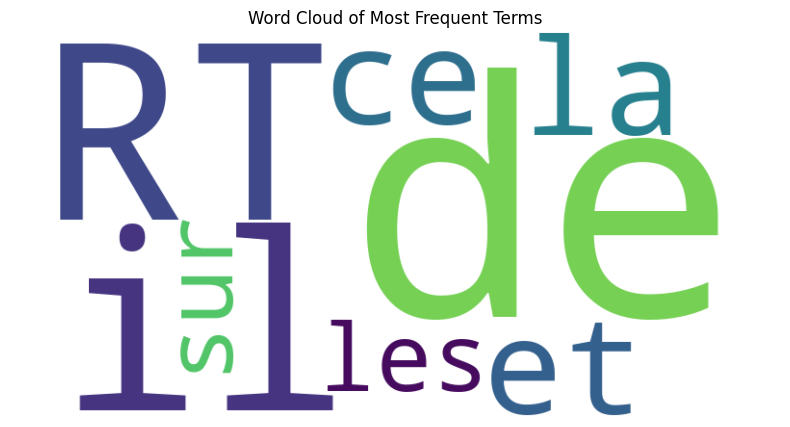

In [33]:
# Convert DataFrame to Pandas DataFrame for visualization
top_keywords_pd = top_keywords.toPandas()

# Create a string of all keywords
wordcloud_text = ' '.join(top_keywords_pd["keyword"])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Terms')
plt.show()